# Project: Semantic Book Recommender System

## Overview
This project builds a semantic search engine capable of recommending books based on natural language queries (e.g., *"a story about a robot learning to love"*), rather than simple keyword matching. 

## Scope & Technical Strategy
The pipeline demonstrates the end-to-end lifecycle of a modern NLP application:
1.  **Data Hygiene:** Rigorous cleaning of textual metadata to ensure high-quality embedding generation.
2.  **Vectorisation:** Transforming text into high-dimensional vector space using State-of-the-Art embedding models (OpenAI / Qwen).
3.  **Retrieval:** Implementing a Vector Database (ChromaDB) for efficient similarity search.

## Dataset Selection
We utilise the **"7k Books with Metadata"** dataset.
* **Why 7k?** This volume is the "pedagogical golden." It is large enough to present real-world noise and meaningful semantic clusters, yet sufficiently compact to allow for rapid iteration and local debugging without requiring extreme computational resources. 

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# 1. Data Exploration and Cleaning

The first stage of the pipeline focuses on data integrity. Garbage In, Garbage Out (GIGO) is particularly punitive in vector search; artifacts in the text (like HTML tags or broken encoding) will corrupt the semantic meaning of the resulting embeddings.

## Dataset Source
* **Source:** [Kaggle: 7k Books with Metadata](https://www.kaggle.com/datasets/dylanjcastillo/7k-books-with-metadata)

In [3]:
# Define the data directory using Pathlib for cross-platform compatibility
DATA_DIR = Path("data")

# Enables Seaborn to use matplotlib specific colours (personal preference)
sns.set_color_codes(palette="bright")

# Load the dataset
books = pd.read_csv(DATA_DIR / "books.csv")
books

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0
6806,9788185944609,8185944601,Secrets Of The Heart,NaN,Khalil Gibran,Mysticism,http://books.google.com/books/content?id=XcrVp...,NaN,1993.0,4.08,74.0,324.0
6807,9788445074879,8445074873,Fahrenheit 451,NaN,Ray Bradbury,Book burning,NaN,NaN,2004.0,3.98,186.0,5733.0
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0


## 2. Missing Value Analysis (Nullity Matrix)

Before generating embeddings, we must identify data sparsity. Text-based recommendation engines rely entirely on the presence of useful metadata (descriptions, categories).

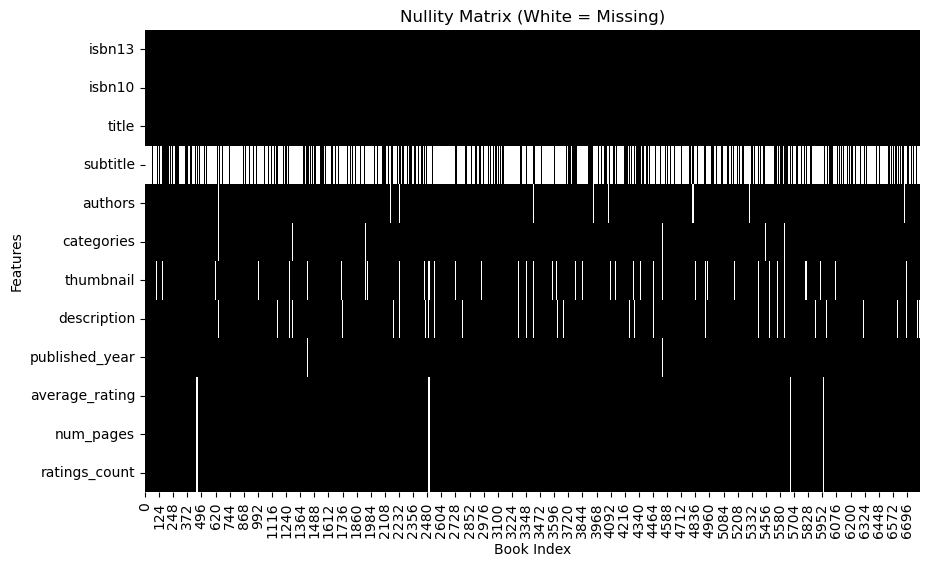

In [4]:
fig, ax = plt.subplots(figsize=(10, 6))

# Transpose (.T) the dataframe so columns are on the Y-axis - increses readability
sns.heatmap(data=books.isna().T, cbar=False, cmap="binary_r", ax=ax)
ax.set(xlabel="Book Index", ylabel="Features", title="Nullity Matrix (White = Missing)")
plt.show()

## 3. Structural Bias & Correlation Check

We perform a check to ensure that "missingness" is not correlated with quality. For instance, if books with missing descriptions systematically have lower ratings, our recommender might accidentally punish niche or unpopular books.

In [5]:
# Create a binary flag: 1 if description is missing, 0 otherwise
books["missing_description"] = np.where(books["description"].isna(), 1, 0)

# Calculate dynamic age (avoiding hardcoded '2026')
current_year = pd.Timestamp.now().year
books["age_of_book"] = current_year - books["published_year"]

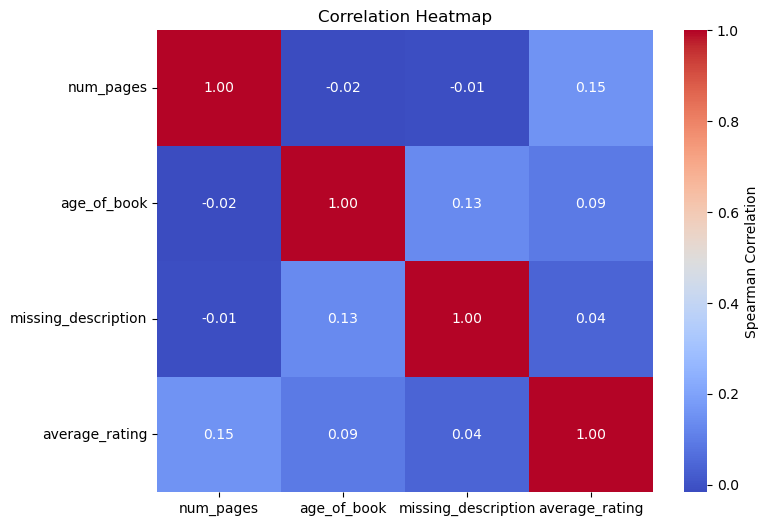

In [6]:
# Select numerical/ordinal columns for interaction analysis
columns_of_interest = ["num_pages", "age_of_book", "missing_description", "average_rating"]

# Compute Spearman Correlation (Robust to outliers/non-normal data)
correlation_matrix = books[columns_of_interest].corr(method="spearman")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={"label": "Spearman Correlation"})
ax.set_title("Correlation Heatmap")
plt.show()

## 4. Data Cleaning

Based on the correlation analysis, it's clear that missing descriptions are **not** correlated with book quality (`average_rating`). This confirms that the missing data is likely at random.

Therefore, we can safely drop incomplete records without introducing significant bias.

**Filtering Criteria:**
We remove any row that lacks data in the following critical columns:
* `description`: Essential for generating vector embeddings.
* `num_pages`: Used for metadata filtering (e.g., "short books").
* `average_rating` & `published_year`: Used for sorting and context.

In [7]:
book_clean = books[~(books["description"].isna()) & ~(books["num_pages"].isna()) & ~(books["average_rating"].isna()) & ~(books["published_year"].isna())]

In [8]:
book_clean

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,22.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,26.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,44.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,33.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,24.0
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,23.0
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,27.0
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,45.0


## 5. Categorical Distribution & Consolidation

Book datasets often suffer from a "Long Tail" distribution in genres—a few major categories (Fiction, History) dominate, while hundreds of niche categories (e.g., "Antiques & Collectibles") contain only one or two books.

In [9]:
book_clean["categories"].value_counts().reset_index().sort_values(by="count", ascending=False)

,categories,count
0,Fiction,2523
1,Juvenile Fiction,534
2,Biography & Autobiography,391
3,History,258
4,Literary Criticism,164
...,...,...
280,Butlers,1
279,Gardens,1
278,Assassins,1
277,Married people,1


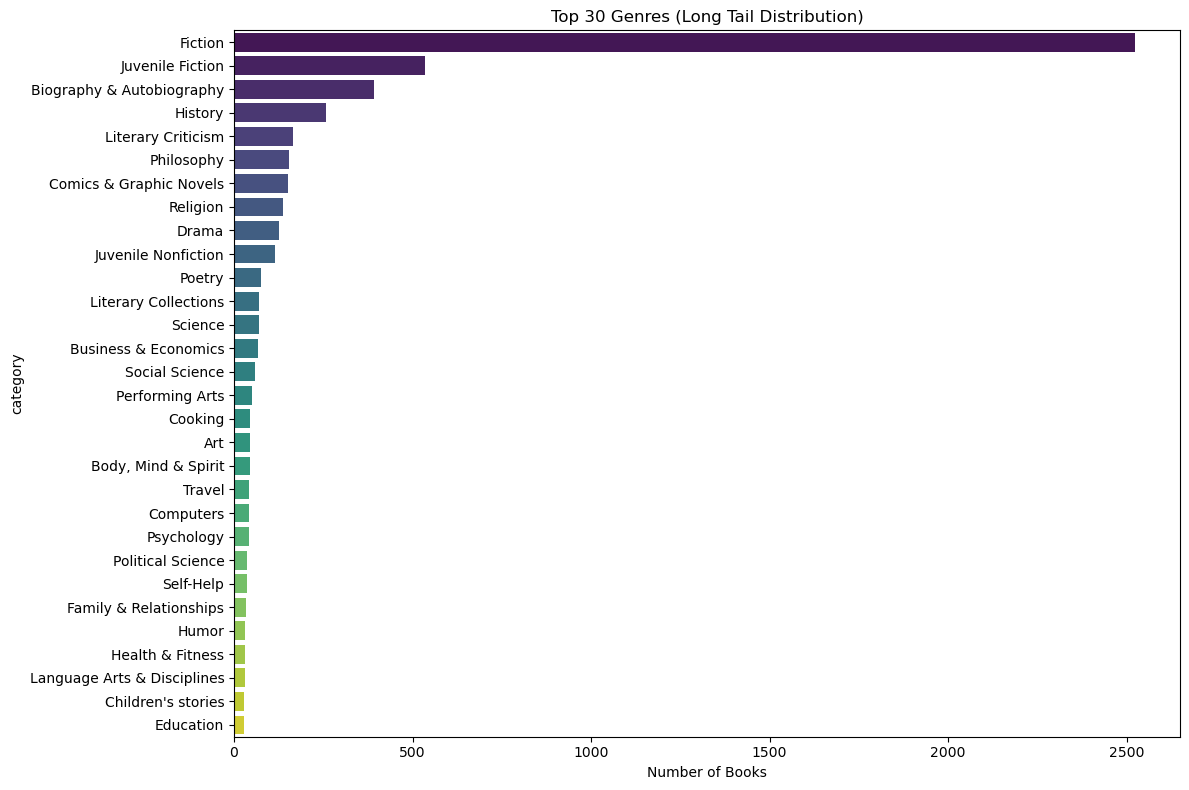

Total unique categories: 531
Sample of rare categories:


categories
Actresses                  1
Apartments                 1
Books                      1
Antislavery movements      1
Indic fiction (English)    1
Name: count, dtype: int64

In [ ]:
# Calculate value counts for all categories
category_counts = book_clean["categories"].value_counts()

# Slice the Top 30 for readability in the plot
plot_data = category_counts.head(30).reset_index()
plot_data.columns = ["category", "count"]

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(data=plot_data, y="category", x="count", hue="category", palette="viridis", legend=False, ax=ax)

ax.set_title("Top 30 Genres (Long Tail Distribution)")
ax.set_xlabel("Number of Books")
plt.tight_layout()
plt.show()

# Quick look at the 'tail' (the messy data we are preserving)
print(f"Total unique categories: {len(category_counts)}")
print("Sample of rare categories:")
display(category_counts.tail(5))

## 6. Text Quality & Length Analysis

To ensure high-quality semantic retrieval, we must filter out "low-information" descriptions. A description with only 5 words (e.g., *"First published in 1993"*) offers no semantic hooks for the embedding model.

1.  **Quantification:** We calculate the word count for every description.
2.  **Visualisation:** We inspect the distribution to find natural cut-off points.
3.  **Thresholding:** After manual inspection of multiple bins, we established a **25-word minimum threshold**. Descriptions shorter than this were found to be predominantly useless.

In [13]:
book_clean = book_clean.copy()
book_clean["words_in_description"] = book_clean["description"].str.split().str.len()
book_clean

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,22.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,26.0,205
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0,0,44.0,14
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,33.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,24.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,24.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,23.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,27.0,174
6808,9789027712059,9027712050,The Berlin Phenomenology,NaN,Georg Wilhelm Friedrich Hegel,History,http://books.google.com/books/content?id=Vy7Sk...,Since the three volume edition ofHegel's Philo...,1981.0,0.00,210.0,0.0,0,45.0,245


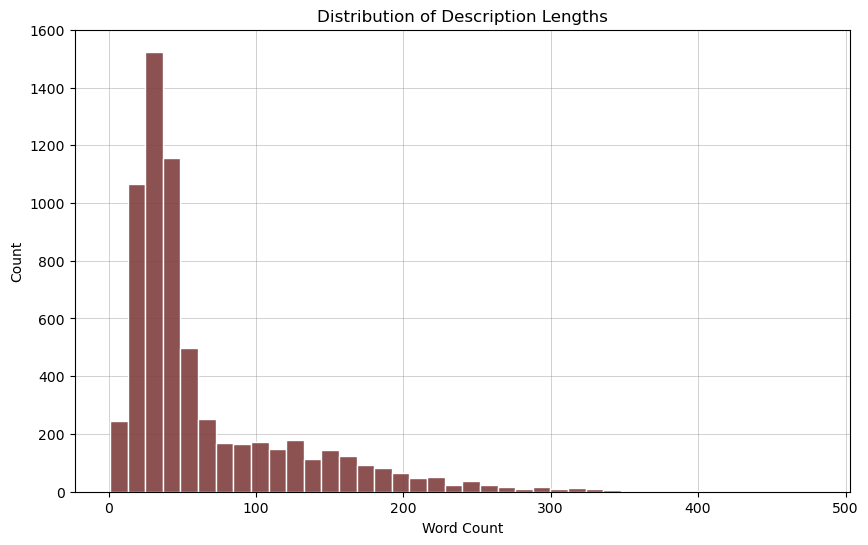

In [ ]:
# Visualise the distribution
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
	data=book_clean[book_clean["words_in_description"] < 500],
	x="words_in_description",
	bins=40,
	color="#803E3E",
	edgecolor="white",
	alpha=0.9,
	ax=ax,
)
ax.set(title="Distribution of Description Lengths", xlabel="Word Count")
ax.grid(True, alpha=0.5, linewidth=0.5, color="grey")
ax.set_axisbelow(True)
plt.show()

In [19]:
book_clean.loc[book_clean["words_in_description"].between(15, 24), "description"]

10      One of Sidney Sheldon's most popular and bests...
32      Tells the story of three generations of Chines...
36      A magical and fantastic collection of early st...
57      A young drifter finds more than he bargained f...
68      A new 'The Doors of Perception' for the 21st c...
                              ...                        
6767    Everything from the fingerprints of the gods t...
6782    Displays one of America's leading physicist's ...
6783    Basics Illustration 01: Thinking Visually expl...
6789    Provides an introduction to the American artis...
6809    This is a jubilant and rewarding collection of...
Name: description, Length: 947, dtype: object

In [20]:
book_clean.loc[book_clean["words_in_description"].between(25, 34), "description"]

9       Kate Blackwell is an enigma and one of the mos...
14      Available in the U.S. for the first time, this...
20      It is 1937, and Charles Ashworth, a Canon to t...
21      Reissue of the author's most famous and well-l...
46      No one believes a little girl when she insists...
                              ...                        
6760    Joel, an English teacher, has never really lik...
6766    Discusses the historical and intellectual back...
6775    Presents nearly one thousand recipes--from app...
6779    Edited by the creator and executive producer o...
6799    This book is the story of a young girl obsesse...
Name: description, Length: 1229, dtype: object

In [21]:
book_25_words = book_clean[book_clean["words_in_description"] >= 25]
book_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,22.0,199
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,26.0,205
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,33.0,57
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,24.0,45
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,24.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,23.0,288
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,24.0,63
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,23.0,117
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,27.0,174


## 7. Feature Engineering & Export

Before saving the clean dataset, we construct the final fields required for the application layer.

**Transformations:**
1.  **Full Title:** We merge `title` and `subtitle` into a single coherent display string.
2.  **Tagged Description (Critical):** We prepend the `isbn13` to the `description`.

In [ ]:
book_25_words = book_25_words.copy()
book_25_words["title_and_subtitle"] = np.where(book_25_words["subtitle"].isna(), book_25_words["title"], book_25_words[["title", "subtitle"]].astype(str).agg(": ".join, axis=1))
book_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,22.0,199,Gilead
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,26.0,205,Spider's Web: A Novel
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,33.0,57,Rage of angels
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,24.0,45,The Four Loves
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,24.0,75,The Problem of Pain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,23.0,288,Mistaken Identity
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,24.0,63,Journey to the East
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,23.0,117,The Monk Who Sold His Ferrari: A Fable About F...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,27.0,174,I Am that: Talks with Sri Nisargadatta Maharaj


In [23]:
book_25_words["tagged_description"] = book_25_words[["isbn13", "description"]].astype(str).agg(" ".join, axis=1)
book_25_words

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count,missing_description,age_of_book,words_in_description,title_and_subtitle,tagged_description
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0,0,22.0,199,Gilead,9780002005883 A NOVEL THAT READERS and critics...
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0,0,26.0,205,Spider's Web: A Novel,9780002261982 A new 'Christie for Christmas' -...
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0,0,33.0,57,Rage of angels,"9780006178736 A memorable, mesmerizing heroine..."
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0,0,24.0,45,The Four Loves,9780006280897 Lewis' work on the nature of lov...
5,9780006280934,0006280935,The Problem of Pain,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=Kk-uV...,"""In The Problem of Pain, C.S. Lewis, one of th...",2002.0,4.09,176.0,37569.0,0,24.0,75,The Problem of Pain,"9780006280934 ""In The Problem of Pain, C.S. Le..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6802,9788172235222,8172235224,Mistaken Identity,NaN,Nayantara Sahgal,Indic fiction (English),http://books.google.com/books/content?id=q-tKP...,On A Train Journey Home To North India After L...,2003.0,2.93,324.0,0.0,0,23.0,288,Mistaken Identity,9788172235222 On A Train Journey Home To North...
6803,9788173031014,8173031010,Journey to the East,NaN,Hermann Hesse,Adventure stories,http://books.google.com/books/content?id=rq6JP...,This book tells the tale of a man who goes on ...,2002.0,3.70,175.0,24.0,0,24.0,63,Journey to the East,9788173031014 This book tells the tale of a ma...
6804,9788179921623,817992162X,The Monk Who Sold His Ferrari: A Fable About F...,NaN,Robin Sharma,Health & Fitness,http://books.google.com/books/content?id=c_7mf...,"Wisdom to Create a Life of Passion, Purpose, a...",2003.0,3.82,198.0,1568.0,0,23.0,117,The Monk Who Sold His Ferrari: A Fable About F...,9788179921623 Wisdom to Create a Life of Passi...
6805,9788185300535,8185300534,I Am that,Talks with Sri Nisargadatta Maharaj,Sri Nisargadatta Maharaj;Sudhakar S. Dikshit,Philosophy,http://books.google.com/books/content?id=Fv_JP...,This collection of the timeless teachings of o...,1999.0,4.51,531.0,104.0,0,27.0,174,I Am that: Talks with Sri Nisargadatta Maharaj,9788185300535 This collection of the timeless ...


In [ ]:
(book_25_words.drop(["subtitle", "missing_description", "age_of_book", "words_in_description"], axis=1).to_csv("data/books_cleaned.csv", index=False))